In [4]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

import myfunc

%matplotlib inline

# Feature impotance

In [5]:
# Prepares movie data.

movie_set = myfunc.make_movie_set()

In [27]:
# Alternate to preparing movie data - loads prepared movie data.

movie_set = pd.read_csv('data/reg_movie_set.csv')

In [7]:
# Sets up the train-test split
X = movie_set.drop('Gross', axis=1)
y = movie_set['Gross']

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=99)

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# Sanity check
print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)

Train - Predictors shape (472, 43)
Test - Predictors shape (148, 43)
Train - Target shape (472, 1)
Test - Target shape (148, 1)


In [10]:
# Scales the training data.

scaler = StandardScaler()

x_train_standard = scaler.fit_transform(x_train)
x_val_standard = scaler.transform(x_val)

In [15]:
# Gets a score from a linear regression - starting point.

linear_regression = LinearRegression()
linear_regression.fit(x_train_standard, y_train)
linear_regression.score(x_train_standard, y_train)

0.6015598392405963

In [16]:
linear_regression.score(x_val_standard, y_val)

0.6346387499426862

In [17]:
# Runs LassoCV on scaled data.

kfold = KFold(shuffle=True, random_state=2**32-1)
lasso_cv = LassoCV(alphas=np.arange(734480, 734490, 1), normalize=False, cv=kfold)
lasso_cv.fit(x_train_standard, y_train)

LassoCV(alphas=array([734480, 734481, 734482, 734483, 734484, 734485, 734486, 734487,
       734488, 734489]),
        cv=KFold(n_splits=5, random_state=4294967295, shuffle=True))

In [19]:
alphas = lasso_cv.alphas_
errors = lasso_cv.mse_path_
n_folds = 5

df_errors = pd.DataFrame(index=alphas, columns=[f'fold_{i+1}' for i in range(n_folds)], data=errors)
df_errors['error_mean'] = df_errors.mean(axis=1)
df_errors.sort_values('error_mean').head()

,fold_1,fold_2,fold_3,fold_4,fold_5,error_mean
734485,4.295034e+15,6.743862e+15,4.544695e+15,2.762819e+15,8.964603e+15,5.462203e+15
734484,4.295049e+15,6.743855e+15,4.544694e+15,2.762818e+15,8.964598e+15,5.462203e+15
734486,4.295017e+15,6.743871e+15,4.544696e+15,2.762820e+15,8.964609e+15,5.462203e+15
734483,4.295063e+15,6.743848e+15,4.544694e+15,2.762817e+15,8.964593e+15,5.462203e+15
734487,4.295000e+15,6.743883e+15,4.544697e+15,2.762820e+15,8.964615e+15,5.462203e+15


In [20]:
lasso_cv.alpha_

734485

In [29]:
lasso_cv.score(x_val_standard, y_val)

0.6215319961732839

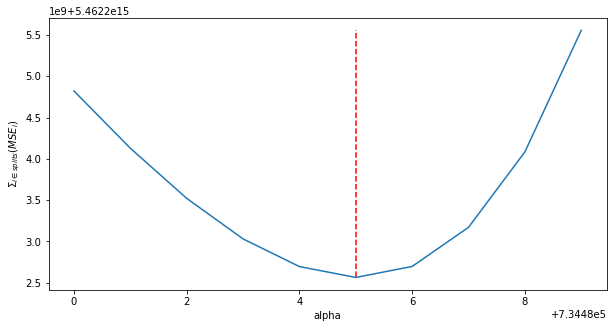

In [21]:
plt.figure(figsize=(10, 5))

g = sns.lineplot(data=df_errors,
                 x=df_errors.index,
                 y='error_mean')

# Show the selected alpha, above
plot_alpha = 734485
g.vlines(plot_alpha, df_errors['error_mean'].min(), df_errors['error_mean'].max(), 
         color='red', linestyles='dashed')

g.set_xlabel('alpha')
g.set_ylabel('$\Sigma_{i \in splits}(MSE_i)$');

In [26]:
cols = movie_set.drop('Gross', axis=1).columns
pd.Series(index=cols, data=lasso_cv.coef_)

UserRating                         2.571912e+07
Metascore                          1.841826e+07
Budget                             3.906805e+07
Theaters                           3.815422e+07
WaltDisneyStudiosMotionPictures    1.130631e+07
UniversalPictures                  4.325280e+06
TwentiethCenturyFox               -0.000000e+00
SonyPicturesEntertainment(SPE)     4.418981e+06
ParamountPictures                 -2.632394e+06
WarnerBros.                       -1.264819e+05
PG                                -7.175569e+06
PG-13                              0.000000e+00
R                                  0.000000e+00
1                                 -0.000000e+00
2                                  2.009860e+06
3                                 -2.070284e+06
4                                  0.000000e+00
5                                 -1.477932e+06
6                                  1.471959e+06
7                                  9.478217e+05
8                                  1.331

# RE run linear regression

In [31]:
x_train2 = x_train.copy()
x_train2.drop(inplace=True, columns=['WarnerBros.', 'PG-13', 'R', 1, 8, 'DirMS', 'Animation', 'Romance', 'Thea2'])
y_train2 = y_train.copy()

x_val2 = x_val.copy()
x_val2.drop(inplace=True, columns=['WarnerBros.', 'PG-13', 'R', 1, 8, 'DirMS', 'Animation', 'Romance', 'Thea2'])
y_val2 = y_val.copy()
scaler = StandardScaler()
x_train2_scaled = scaler.fit_transform(x_train2)
x_val2_scaled = scaler.transform(x_val2)

linear_regression = LinearRegression()
linear_regression.fit(x_train2_scaled, y_train2)
linear_regression.score(x_train2_scaled, y_train2)

0.6011222442871085

In [33]:
linear_regression.score(x_val2_scaled, y_val2)

0.6354679914947068

In [357]:
x_test2_scaled = scaler.transform(x_test2)
lr.score(x_test2_scaled, y_test2)

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [173]:
for i in range(-10,5):
    m = Ridge(alpha=10**i)
    m.fit(X_standard, y_standard)
    print(m.coef_,m.score(x_test,y_test))

[[ 0.28756151  0.25443291  0.39811626  0.17129261  0.12398269  0.01440085
  -0.02615448  0.00231908 -0.03983435 -0.05007518 -0.05746584  0.01791268
   0.03210395  0.00128296  0.06680899 -0.02658388  0.00938247 -0.03659295
   0.0125577   0.01419282 -0.00082224 -0.03601387 -0.02715221 -0.05415691
   0.06393414 -0.14103243 -0.07791156 -0.06762338 -0.06436217  0.02546785
  -0.01297316 -0.00469229 -0.04863325 -0.11212799  0.06119554 -0.01615566
  -0.03821828 -0.06475752  0.01215051 -0.01926979  0.0040451   0.00481156
   0.17106732]] -0.15776422090691944
[[ 0.28756151  0.25443291  0.39811626  0.17119329  0.12360554  0.01393294
  -0.02659407  0.0019105  -0.0402344  -0.05058955 -0.05772572  0.01759651
   0.03180598  0.00138574  0.06693896 -0.02645769  0.00949172 -0.03646421
   0.01268517  0.01433437 -0.00070272 -0.03588767 -0.02700958 -0.05401536
   0.06409946 -0.14103243 -0.07791156 -0.06762338 -0.06436217  0.02546785
  -0.01297316 -0.00469229 -0.04863325 -0.11212799  0.06119554 -0.01615566
 

In [171]:
m = RidgeCV()
m.fit(X_standard, y_standard)
print(m.coef_,m.score(x_test,y_test))

[[ 2.60401614e-01  2.37670334e-01  3.76743158e-01  1.71780771e-01
   1.24952261e-01  1.25712203e-02 -2.78057910e-02  1.91399194e-03
  -4.00054158e-02 -4.96972849e-02 -5.70984011e-02  1.84532552e-02
   3.02200999e-02 -1.32697875e-04  6.47227722e-02 -2.50691300e-02
   9.58601204e-03 -3.45526319e-02  1.37299645e-02  1.37337939e-02
  -1.94203882e-03 -3.57300818e-02 -2.79060884e-02 -5.31122404e-02
   6.47918118e-02 -1.11944295e-01 -6.38681984e-02 -6.13600818e-02
  -5.36248588e-02  2.99782394e-02 -1.03943720e-02 -5.36140460e-04
  -4.27772299e-02 -1.06778325e-01  6.04688912e-02 -1.38227852e-02
  -3.29246493e-02 -5.94072146e-02  1.38001404e-02 -1.90147348e-02
   2.45572968e-03  4.96541518e-03  1.71780771e-01]] -0.18608147137429532


In [174]:
for i in range(-10,5):
    m = Lasso(alpha=10**i)
    m.fit(X_standard, y_standard)
    print(m.coef_,m.score(x_test,y_test))

[ 0.28756151  0.25443291  0.39811626  0.33014063  0.15018986  0.04691461
  0.00439131  0.03071007 -0.01203589 -0.01433311 -0.0813884  -0.01119152
  0.00467608  0.00256294  0.06842766 -0.02501229  0.01074302 -0.03498975
  0.0141452   0.01595567  0.00066624 -0.03444227 -0.0253759  -0.05239406
  0.06599292 -0.14103243 -0.07791156 -0.06762338 -0.06436217  0.02546785
 -0.01297316 -0.00469229 -0.04863325 -0.11212799  0.06119554 -0.01615566
 -0.03821828 -0.06475752  0.01215051 -0.01926979  0.0040451   0.00481156
  0.01221929] -0.15776422154929715
[ 0.28756151  0.2544329   0.39811626  0.33014064  0.1501894   0.04691404
  0.00439077  0.03070957 -0.01203638 -0.01433374 -0.08138789 -0.0111909
  0.00467666  0.00256273  0.06842739 -0.02501254  0.0107428  -0.03499001
  0.01414494  0.01595538  0.000666   -0.03444253 -0.02537618 -0.05239434
  0.06599258 -0.14103242 -0.07791155 -0.06762337 -0.06436216  0.02546785
 -0.01297316 -0.00469228 -0.04863324 -0.11212799  0.06119554 -0.01615566
 -0.03821828 -0.0

In [176]:
m = LassoCV()
m.fit(X_standard, y_standard)
print(m.coef_,m.score(x_test,y_test))

[ 0.23458992  0.18525683  0.3568056   0.33847941  0.13745269  0.03334624
 -0.          0.01581841 -0.00802674 -0.01483656 -0.06407541 -0.
  0.00254919  0.          0.05621909 -0.01413669  0.00594899 -0.02172874
  0.01161887  0.00847432 -0.         -0.02718034 -0.01929277 -0.04474237
  0.06144176 -0.09438878 -0.00797567 -0.0438731  -0.03107814  0.03210875
 -0.          0.00680438 -0.01878372 -0.09111492  0.05443538 -0.
 -0.01518659 -0.04004286  0.01386902 -0.00693605 -0.          0.00096298
  0.        ] -0.21327381830260728


In [47]:
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=2**32-1)

In [85]:
grid = GridSearchCV(estimator=Lasso(normalize=True),  # must be an sklearn estimator
                    param_grid={'alpha': np.arange(25563, 25566, 0.01)},
                    cv=kfold,
                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
                    return_train_score=True)
grid.fit(X, y)
grid.best_estimator_

Lasso(alpha=25564.909999999694, normalize=True)

In [86]:
grid.best_score_

-5271191518784130.0

This is promising - When I run this over x_standard, y_standard instead of x_train, y_train, score is very high.  Run on x_train_standard.

In [229]:
# Polynomial fit - pair_regressions2
# X_standard is x_train scaled.


p = PolynomialFeatures(degree=2,interaction_only=True)
x_train_poly = p.fit_transform(X_standard)
m.fit(x_train_poly, y_train)
m.score(x_train_poly, y_train)
m.score(x_test_poly, y_test)

0.535662931369908

In [ ]:
Is this ready for running test set?
Do I nead to scale test set?


# Do I run prediction on scaled inputs?

In [186]:
movie_set.columns

Index([                     'UserRating',                       'Metascore',
                                'Budget',                           'Gross',
                              'Theaters', 'WaltDisneyStudiosMotionPictures',
                     'UniversalPictures',             'TwentiethCenturyFox',
        'SonyPicturesEntertainment(SPE)',               'ParamountPictures',
                           'WarnerBros.',                              'PG',
                                 'PG-13',                               'R',
                                       1,                                 2,
                                       3,                                 4,
                                       5,                                 6,
                                       7,                                 8,
                                       9,                                10,
                                      11,                                12,

In [202]:
greyhound = pd.Series([7.0, 64, 50300000, 4300, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7.0, 77, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).values.reshape(1, 43)
m.predict(greyhound)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 947 is different from 43)

In [ ]:
m.score(p.transform(x_test),y_test)

In [181]:
# Polynomial fit - pair_regressions2
p = PolynomialFeatures(degree=2,interaction_only=True)
x_train_poly = p.fit_transform(x_train)
m.fit(x_train_poly,y_train)
m.score(x_train_poly,y_train)

0.5084746550078967

In [184]:
m.score(p.transform(x_test),y_test)

-77683.04901053463

Lasso(alpha=11000, normalize=True)

In [7]:
movie_set_corr = movie_set.corr()

(44.5, -0.5)

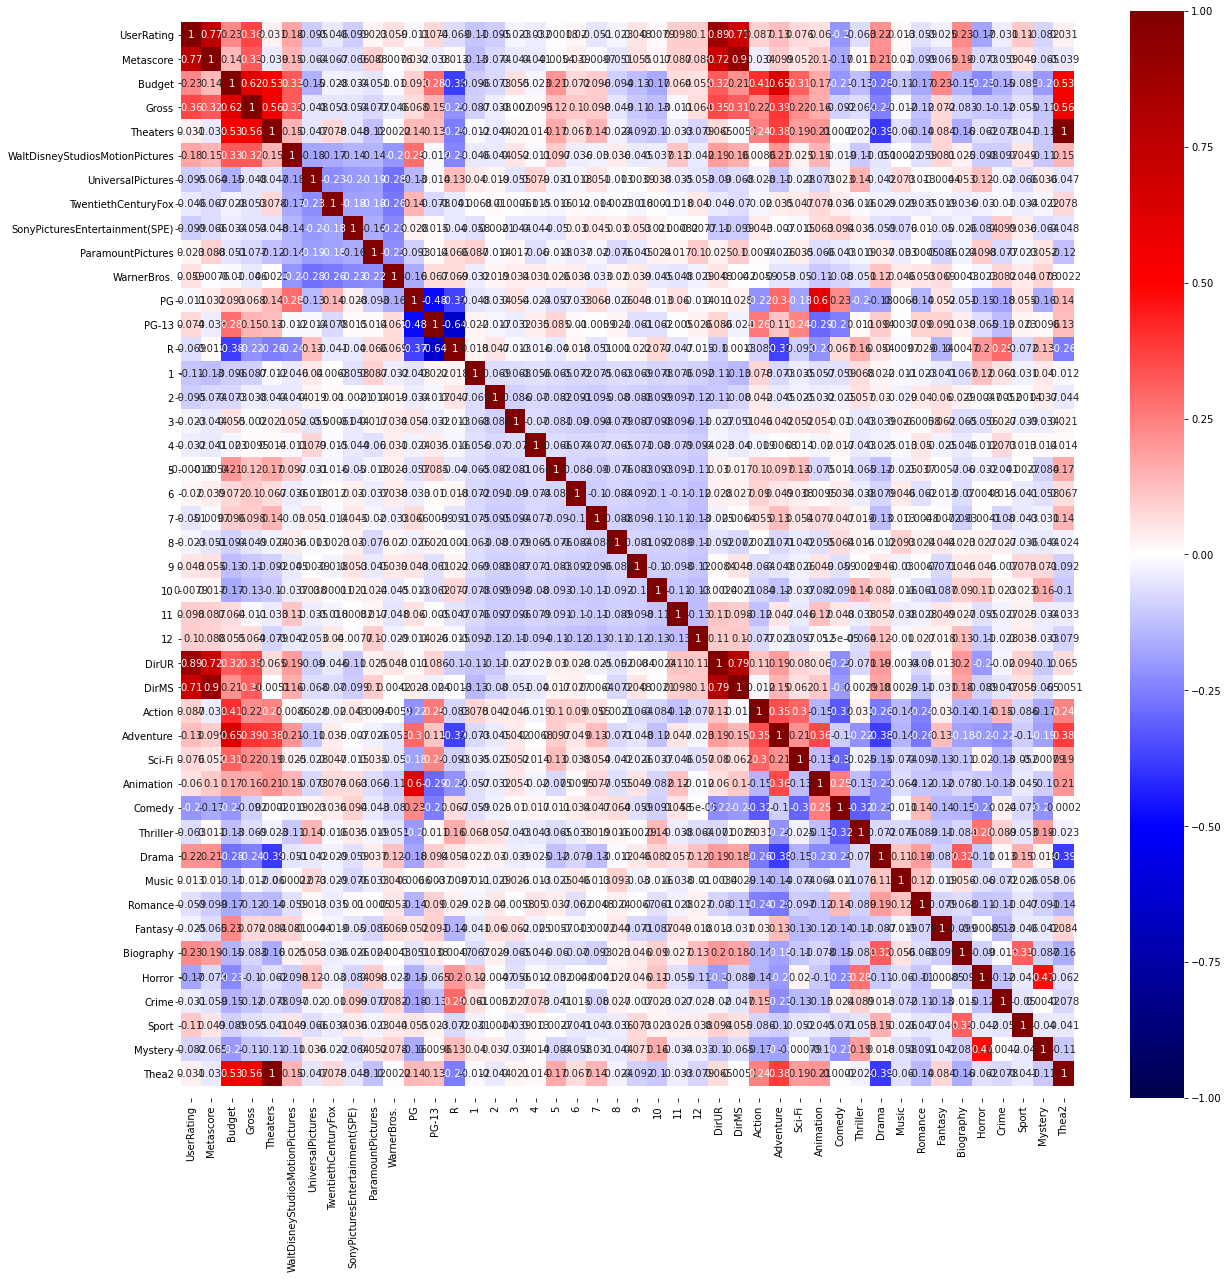

In [32]:
plt.figure(figsize=(20, 20))

sns.heatmap(movie_set_corr,
            cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.gca().set_ylim(len(movie_set_corr)+0.5, -0.5)

In [ ]:
# sns.pairplot(movie_set, height=1.5, aspect=1)
g = sns.PairGrid(movie_set.sample(frac=0.6), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False)

In [ ]:
lr = LinearRegression()

X = movie_set['Budget'].values.reshape(-1, 1)
# X = movie_set['Theaters', 'UserRating', 'MetaScore', 'Budget', 'PG', 'PG-13', 'R', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'].values.reshape(-1, 1)
y = movie_set['Gross']

lr.fit(X, y)
lr.score(X, y)

In [ ]:
lr.predict([[100000000],[200000000]])

In [ ]:
X = movie_set[['Budget', 'DirUR', 'Theaters']]
y = movie_set['Gross']

lr.fit(X, y)
lr.score(X, y)

In [ ]:
lr.predict([[100000000, 7.9, 4300]])

In [ ]:
X = movie_set.copy()
del X['Gross']
y = movie_set['Gross']

lr_full.fit(X, y)
lr_full.score(X, y)

In [ ]:
sm.add_constant(X).head()

In [ ]:
model = sm.OLS(y, sm.add_constant(X))

fit = model.fit()
fit.summary()

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(fit.predict(), fit.resid)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

In [ ]:
plt.figure(figsize=(10, 6))
sns.jointplot(x=movie_set['Theaters'], y=movie_set['Gross'], data=movie_set, kind='reg');

## Splitting data into test and train

In [ ]:
x_train

In [ ]:
prediction = cls.predict(x_test)

In [ ]:
cls.get_params()

In [ ]:
print('Co-efficient of linear regression',cls.coef_)
print('Intercept of linear regression model',cls.intercept_)
print('Mean Square Error', metrics.mean_squared_error(y_test, prediction))
print('Model R^2 Square value', metrics.r2_score(y_test, prediction))

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test)
plt.plot(x_test, prediction, color='red', linewidth=3)
plt.xlabel('Hours')
plt.ylabel('Marks')
plt.title('Linear Regression');

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cls.predict(x_test), cls.predict(x_test) - y_test, c='g', s = 40)
plt.hlines(y=0, xmin=0, xmax=100)
plt.title('Residual plot')
plt.ylabel('Residual');

## Polynomial Regression

In [198]:
lr_full = LinearRegression()

X = movie_set[['Theaters', 'WaltDisneyStudiosMotionPictures', 'UniversalPictures', 'TwentiethCenturyFox', 'SonyPicturesEntertainment(SPE)', 'ParamountPictures', 'WarnerBros.']]
y = movie_set['Gross']

lr_full.fit(X, y)
lr_full.score(X, y)

0.3729334726239232

In [200]:
lr_full.predict([[4300,1,0,0,0,0,0]])

array([2.45138241e+08])

In [ ]:
p = PolynomialFeatures()

X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)

In [ ]:
X.shape
X_poly.shape

In [ ]:
dataset = movie_set
X = dataset[['Theaters']].values  
y = dataset.loc[:,'Gross'].values

plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
plt.style.use('default')

# fig = plt.figure(figsize=(12, 4)), 2))
y = np.reshape(y, (-1, 1))
# fitting the linear regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
 
# visualising the linear regression model
plt.scatter(X,y, color='red')
plt.plot(X, lin_reg.predict(X),color='blue')
plt.title("Gross by Theaters (Linear)")
plt.xlabel('Number of Theaters')
plt.ylabel('Gross')
plt.show()
 
# polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
 
 
# visualising polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
X_grid = np.arange(min(X),max(X),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X,y, color='red') 
  
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
  
plt.title("Gross by Theaters (Polynomial)")
plt.xlabel('Number of Theaters')
plt.ylabel('Gross')
plt.show()

In [ ]:
dataset = movie_set
X = dataset[['UserRating']].values  
y = dataset.loc[:,'Gross'].values

plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
plt.style.use('default')

# fig = plt.figure(figsize=(12, 4)), 2))
y = np.reshape(y, (-1, 1))
# fitting the linear regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
 
# visualising the linear regression model
plt.scatter(X,y, color='red')
plt.plot(X, lin_reg.predict(X),color='blue')
plt.title("Gross by User Rating (Linear)")
plt.xlabel('User Rating')
plt.ylabel('Gross')
plt.show()
 
# polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
 
 
# visualising polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
X_grid = np.arange(min(X),max(X),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X,y, color='red') 
  
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
  
plt.title("Gross by User Rating (Polynomial)")
plt.xlabel('Number of User Rating')
plt.ylabel('Gross')
plt.show()

In [ ]:
# dataset = movie_set
# X = dataset[['Theaters','WaltDisneyStudiosMotionPictures']].values  
# Y = dataset.loc[:,'Gross'].values
# X = np.reshape(X, (-1, 2))
# Y = np.reshape(y, (-1, 1))

# x = X[:, 0]
# y = X[:, 1]
# z = Y
# x = np.reshape(x, (-1, 1))
# y = np.reshape(y, (-1, 1))

# xx_pred, yy_pred = np.meshgrid(dataset['Theaters'], dataset['WaltDisneyStudiosMotionPictures'])
# model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# # fitting the linear regression model
# from sklearn.linear_model import LinearRegression
# lin_reg = LinearRegression()
# model = lin_reg.fit(X, Y)
# predicted = model.predict(model_viz)
# r2 = model.score(X, Y)

# plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# axes = [ax1, ax2, ax3]

# for ax in axes:
#     # ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('Porosity (%)', fontsize=12)
#     ax.set_ylabel('Brittleness', fontsize=12)
#     ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax3.transAxes, color='grey', alpha=0.5)

# ax1.view_init(elev=28, azim=120)
# ax2.view_init(elev=4, azim=114)
# ax3.view_init(elev=60, azim=165)

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

# fig.tight_layout()

In [ ]:
r2 ** 0.5

In [ ]:
predicted.shape